In [1]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, ToPILImage, Resize, Compose
from torch import nn
from torch.nn import functional as F
from torchvision.models import vgg11, vgg16


In [2]:
import os
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from PIL import Image as pilimage

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
from IPython.display import clear_output 

In [3]:
class Person:
    def __init__(self, name):
        self.name = name
        self.new = []
        self.old = []
        self.resize = Resize((224, 224))

    def add(self, age, num):
        pic = self.resize(
                  pilimage.open('../data/CACD2000/'+ str(age) + '_' + self.name + '_' + str(num) + '.jpg') #TODO format
              )
        if int(age) > 30:
            self.old.append(pic)
        else:
            self.new.append(pic)
            
    def get_old(self):
        return random.sample(self.old, 1)[0]
    def get_new(self):
        return random.sample(self.new, 1)[0]

In [4]:
# class Image:
#     def __init__(self, age, fname, sname, num):
#         self.age = age
#         self.fname = fname
#         self.sname = sname
#         self.num = num
#         self.image = None
#         self.resize = Resize((224, 224))
        
#     def get_pilimage(self):
#         if self.image is None:
#             self.image = pilimage.open(
#                 '../data/CACD2000/'+'_'.join([self.age, self.fname, self.sname, self.num]) + '.jpg'
#             )
#         return self.resize(self.image)
    
#     def get_timage(self):
#         if self.image is None:
#             self.image = pilimage.open(
#                 '../data/CACD2000/'+'_'.join([self.age, self.fname, self.sname, self.num]) + '.jpg'
#             )
#         return ToTensor()(self.resize(self.image))


In [5]:
ldir = os.listdir('../data/CACD2000/')
random.sample(ldir, 5)

['24_Scott_Eastwood_0006.jpg',
 '41_Amanda_Peet_0012.jpg',
 '44_Jennifer_Aniston_0004.jpg',
 '28_Ruth_Wilson_0004.jpg',
 '44_Wes_Anderson_0003.jpg']

In [6]:
persons = {}
for image in tqdm(os.listdir('../data/CACD2000/')):
    info = image[:-4].split('_')
    name = '_'.join(info[1:-1])
    try:
        persons[name].add(info[0], info[-1])
    except Exception:
        persons[name] = Person(name)
        persons[name].add(info[0], info[-1])

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [7]:
class AgeDataset(Dataset):
    def __init__(self, persons):
        self.persons = persons
        self.keys = list(persons.keys())
        
    def __len__(self):
        return len(self.persons) # 163446
    
    def __getitem__(self, ind):
        flag = 1
        while flag:
            pers = random.sample(self.keys, 1)[0]
            pers = persons[pers]
            try:
                new = pers.get_new()
                old = pers.get_old()
            except ValueError:
                continue
            flag = 0
        return ToTensor()(new), ToTensor()(old)
        # return new, old

In [8]:
ageset = AgeDataset(persons)
ageloader = DataLoader(ageset, batch_size=4)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 9, 1, 4),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.ress = nn.ModuleList([nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )] * 4)
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 12, 1, 4),
        )
    
    def forward(self, x): # херня с резблоками
        x = self.conv(x)
        for conv in self.ress:
            x = conv(x) + x
        # return F.sigmoid(self.upconv(x))
        return self.upconv(x)

In [10]:
# del generator
# del new
# del old
# del optim
# torch.cuda.empty_cache()


In [11]:
# generator = Generator().cuda()
# criterion = nn.MSELoss()
# optim = torch.optim.Adam(generator.parameters())

In [12]:
# losses = []
# generator.train()

# for epoch in tqdm(range(100), desc='epoch'):
#     for new, old in tqdm(ageloader, leave=False, desc='train'):
#         new, old = new.cuda(), old.cuda()
#         optim.zero_grad()
#         old_gen = generator(new)
#         loss = criterion(old_gen, new)
#         loss.backward()
#         optim.step()
# #         losses.append(loss.item())
# #     plt.plot(losses)
# #     plt.show()


In [13]:
lfw_dset = ImageFolder('../data/lfw-deepfunneled/', transform=Compose([Resize((224, 224)), ToTensor()]))
lfw_dloader = DataLoader(lfw_dset, batch_size=8)

In [14]:
len(lfw_dset.classes)

5749

In [15]:
from torchvision.models import vgg11, vgg16, resnet18

identity_model = resnet18(num_classes=len(lfw_dset.classes)).cuda()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(identity_model.parameters())

In [ ]:
epoch_losses = []
identity_model.train()

for epoch in tqdm(range(50), desc='epoch'):
    losses = []
    for photo, target in tqdm(lfw_dloader, leave=False, desc='train'):
        photo, target = photo.cuda(), target.cuda()
        optim.zero_grad()
        preds = identity_model(photo)
        loss = criterion(preds, target)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    epoch_losses.append(np.mean(losses))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
plt.plot(epoch_losses)
plt.show()

In [ ]:
class TripletDataset(Dataset):
    def __init__(self, lfw_dset):
        self.lfw_dset = lfw_dset
        self.images = defaultdict(list)
        for img, class_ind in lfw_dset.imgs:
            self.images[class_ind].append(img)
        self.anchors = {class_ind: self.images[class_ind] for class_ind in self.images.keys() if len(self.images[class_ind]) > 3}
        
        
    def __len__(self):
        return len(self.anchors)*2
    
    def __getitem__(self, ind):
        anchor = random.sample(self.anchors.keys(), 1)[0]
        far = random.sample(self.images.keys(), 1)[0]
        anchor, close = random.sample(self.anchors[anchor], 2)
        far = random.sample(self.images[far], 1)[0]
        return self.lfw_dset.transform(self.lfw_dset.loader(anchor)), \
               self.lfw_dset.transform(self.lfw_dset.loader(close)), \
               self.lfw_dset.transform(self.lfw_dset.loader(far))
        

In [ ]:
identity_model.fc = nn.Linear(in_features=512, out_features=512, bias=True).cuda()

In [ ]:
identity_model.fc

In [ ]:
triplet_dataset = TripletDataset(lfw_dset)
triplet_loader = DataLoader(triplet_dataset, batch_size=8)
criterion = torch.nn.MarginRankingLoss(margin = 0.2) # mb change
optim = torch.optim.Adam(identity_model.parameters(), lr=0.0001)

In [ ]:
epoch_losses = []
identity_model.train()

for epoch in tqdm(range(30), desc='epoch'):
    losses = []
    for anchor, close, far in tqdm(triplet_loader, leave=False, desc='train'):
        anchor, close, far = anchor.cuda(), close.cuda(), far.cuda()
        optim.zero_grad()
        anchor, close, far = identity_model(anchor), \
                             identity_model(close), \
                             identity_model(far)
        target = torch.FloatTensor(anchor.size(0)).fill_(1).cuda()
        loss = criterion(torch.pow(F.pairwise_distance(anchor, far), 2), \
                         torch.pow(F.pairwise_distance(anchor, close), 2), \
                         target)
        print(loss.item())
        loss.backward()
        optim.step()
        losses.append(loss.item())
    epoch_losses.append(np.mean(losses))

In [ ]:
len(triplet_loader.dataset.anchors)

In [ ]:
# anchor, close, far = next(iter(triplet_loader))
# anchor, close, far = anchor.cuda(), close.cuda(), far.cuda()
# anchor, close, far = identity_model(anchor), \
#                      identity_model(close), \
#                      identity_model(far)


In [ ]:
# F.pairwise_distance(anchor, far)

In [ ]:
# F.pairwise_distance(anchor, close)

In [ ]:
for param in identity_model.parameters():
    param.requires_grad = False


In [ ]:
plt.plot(epoch_losses)
plt.show()

In [184]:
class AgeFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.imgs[index]
        path_ = path.split('/')[-1][:-4].split('_')
        age = int(path_[-1]) - int(path_[1].split('-')[0])
        if age < 10 or age > 90:
            return self.__getitem__(index+1)
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, age


In [185]:
age_set = AgeFolder('../data/wiki_crop/', transform=Compose([Resize((224, 224)), ToTensor()]))


In [186]:
# age_max = 0
# age_min = 100
# for i in tqdm(age_set):
#     age_max = max(age_max, i[1])
#     age_min = min(age_min, i[1])
    
# #     plt.imshow(i[0].numpy().swapaxes(0, 2).swapaxes(0, 1))
# #     plt.title(i[1])
# #     plt.show()
    

In [187]:
# print(age_min, age_max)

In [188]:
age_set = AgeFolder('../data/wiki_crop/', transform=Compose([Resize((224, 224)), ToTensor()]))
age_dloader = DataLoader(age_set, batch_size=8, shuffle=True)
age_model = vgg16(num_classes=len(age_set.classes)).cuda()
optim = torch.optim.Adam(age_model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in tqdm(range(3)):
    losses = []
    for image, target in tqdm(age_dloader, leave=False):
        optim.zero_grad()
        image, target = image.cuda(), target.cuda()
        pred = age_model(image)
        loss = criterion(pred, target)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    print("Epoch {}, mean loss = {}".format(epoch, np.mean(losses)))

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 0, mean loss = 3.97960959385424


In [55]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = age_model.features # # age
        self.path1 = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path2 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        self.path4 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.05),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.05),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.05),
            nn.Conv2d(512, 1, 4, 2, 1),
        )
        for param in self.features:
            param.requires_grad = False
        self.clf = nn.Linear(12*3, 1)
        
    def forward(self, x):
        conv_num = 0
        flag = 0
        results = []
        for module in self.features.modules():
            if flag == 0:
                flag += 1
                continue
            if isinstance(module, nn.Conv2d):
                conv_num+=1
                if conv_num == 2:
                    results.append(self.path4(x))
                if conv_num == 4:
                    results.append(self.path3(x))
                if conv_num == 7:
                    results.append(self.path2(x))
                if conv_num == 10:
                    results.append(self.path1(x))
            x = module(x)
        results = torch.cat(results, dim=1)
        return results
        # return self.clf(results.view(results.size(0), -1)).view(-1)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
# xavier

In [128]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

mse_criterion = nn.MSELoss()

generator_optim = torch.optim.Adam(generator.parameters(), 1e-4, weight_decay=0.5)
discriminator_optim = torch.optim.Adam(discriminator.parameters(), 1e-4, weight_decay=0.5)

In [129]:
# 0.2 * torch.pow(torch.norm(old_gen - new), 2) / (new.size(1) + new.size(2) + new.size(3) + new.size(0))

In [130]:
# torch.pow(torch.norm(old_gen - new), 2)

In [131]:
# torch.mean(torch.stack([torch.pow(torch.norm(old_gen[i] - new[i]), 2) / (new.size(1) + new.size(2) + new.size(3)) for i in range(new.size(0))]))




In [132]:
# torch.pow(torch.norm(old_gen - new), 2) / (new.size(1) + new.size(2) + new.size(3) + new.size(0))

epoch  29 iter 0 total 500


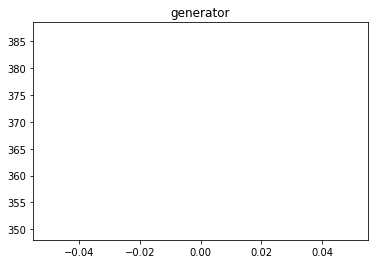

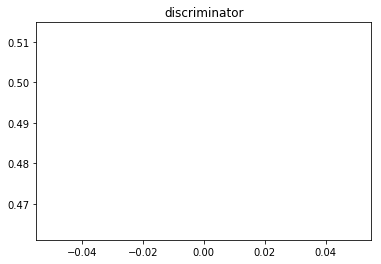

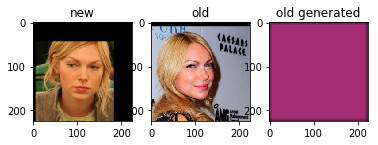

KeyboardInterrupt: 

In [133]:
identity_model.eval()


for epoch in tqdm(range(1000), desc='epoch'):
    gen_losses = []
    disc_losses = []
    generator.train()
    discriminator.train()
    for iter_ind, (new, old) in enumerate(tqdm(ageloader, leave=False, desc='train')):
        new, old = new.cuda(), old.cuda()
        # discrim
        discriminator_optim.zero_grad()
        disc_old = discriminator(old)
        # torch.ones(disc_old.size()).cuda()
        disc_loss = torch.mean(torch.pow(discriminator(old) - 1, 2)) * 0.5 + \
            torch.mean(torch.pow(discriminator(old_gen.detach()), 2) + torch.pow(discriminator(new), 2)) * 0.5
        disc_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        discriminator_optim.step()
        disc_losses.append(disc_loss.item())

        
        
        
        generator_optim.zero_grad()
        old_gen = torch.clamp(generator(new), 0, 1)
        if iter_ind % 2 == 0:
            disc_ans = discriminator(old_gen)
            identity_loss = 0.05/2 * torch.mean(F.pairwise_distance(identity_model(new), identity_model(old_gen)))
            gen_loss = 750/2 * torch.mean(torch.pow(disc_ans - torch.ones(disc_ans.size()).cuda(), 2)) # mean?
            generator_loss = identity_loss + gen_loss
            if iter_ind % 10 == 0:
                objective_loss = 0.2/5 * torch.mean(torch.stack(
                    [torch.pow(torch.norm(old_gen[i] - new[i]), 2) / (new.size(1) + new.size(2) + new.size(3)) for i in range(new.size(0))]
                ))
                generator_loss += objective_loss
            generator_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)
            generator_optim.step()
            gen_losses.append(generator_loss.item())
        # maybe one at a time?
#         old_gen.detach_()
        discriminator_optim.zero_grad()
        disc_old = discriminator(old)
        disc_loss = torch.mean(torch.pow(disc_old - torch.ones(disc_old.size()).cuda(), 2)) * 0.5 + \
            torch.mean(torch.pow(discriminator(old_gen.detach()), 2) + torch.pow(discriminator(new), 2)) * 0.5
        disc_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        discriminator_optim.step()
        disc_losses.append(disc_loss.item())
        if iter_ind % 100 == 0:
            ageloader_eval = DataLoader(ageset, batch_size=1)
            clear_output()
            print('epoch ', epoch, 'iter', iter_ind, 'total', len(ageloader))
            plt.plot(gen_losses)
            plt.title('generator')
            plt.show()
            plt.plot(disc_losses)
            plt.title('discriminator')
            plt.show()
            generator.eval()
            discriminator.eval()
            new, old = next(iter(ageloader_eval))
            new = new.cuda()
#             old_gen = torch.clamp(generator(new), 0, 1)
            plt.subplot(1,3,1)
            plt.title('new')
            plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
            plt.subplot(1,3,2)
            plt.title('old')
            plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
            plt.subplot(1,3,3)
            plt.title('old generated')
            plt.imshow(torch.clamp(generator(new), 0, 1).cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
            plt.show()


In [29]:
ageloader_eval = DataLoader(ageset, batch_size=1)

/home/mrartemev/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


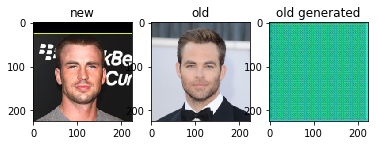

In [30]:
generator.eval()
discriminator.eval()
new, old = next(iter(ageloader_eval))
new = new.cuda()
old_gen = generator(new)
old_gen = (old_gen - old_gen.min())/(old_gen.max() - old_gen.min())
plt.subplot(1,3,1)
plt.title('new')
plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
plt.subplot(1,3,2)
plt.title('old')
plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
plt.subplot(1,3,3)
plt.title('old generated')
plt.imshow(old_gen.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
plt.show()


In [ ]:
ageloader_eval = DataLoader(ageset, batch_size=1)

/home/mrartemev/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


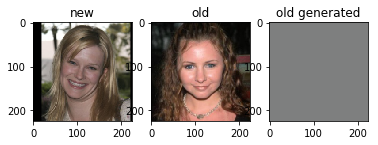

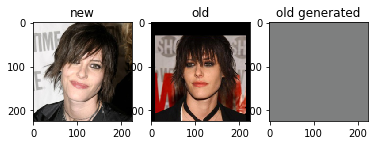

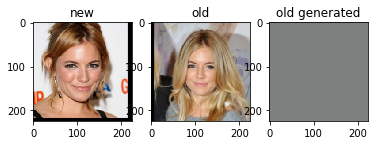

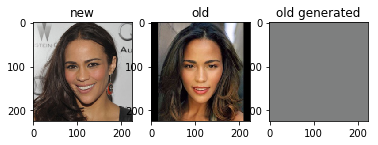

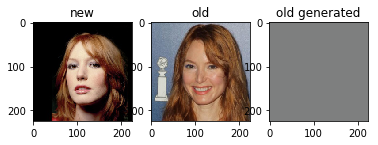

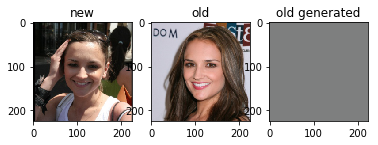

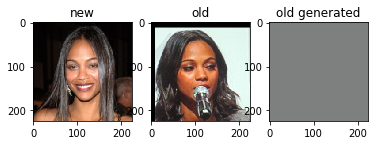

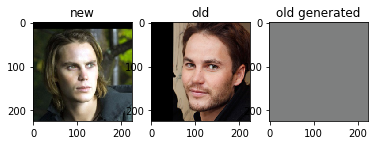

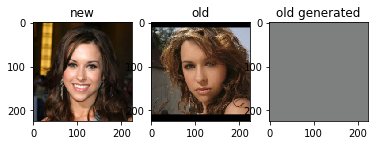

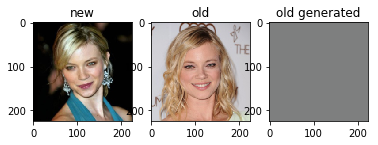

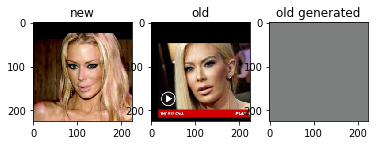

In [33]:
generator.eval()
discriminator.eval()
i = 0
for new, old in tqdm(ageloader_eval):
    i+=1
    new = new.cuda()
    old_gen = generator(new)
    plt.subplot(1,3,1)
    plt.title('new')
    plt.imshow(new.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,2)
    plt.title('old')
    plt.imshow(old.data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.subplot(1,3,3)
    plt.title('old generated')
    plt.imshow(old_gen.cpu().data.numpy()[0].swapaxes(0, 2).swapaxes(0, 1))
    plt.show()
    if i > 10:
        break

In [ ]:
1